# Partie1: Index Building methodology

In [1]:
import pandas as pd 
import numpy as np
import scipy.optimize
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
from arch import arch_model
InputMonthly= pd.read_excel('') # must contain the path for an excel spreadsheet contaning monthly returns of Stoxx Europe 600
InputWeekly= pd.read_excel('')# must contain the path for excel spreadsheet contaning weekly returns of Stoxx Europe 600
SXXP_returns= pd.read_excel('') #must contain the path for an excel spreadsheet containing weekly returns of Stoxx Europe 600


### Compute volatility of each stock

In [2]:
Monthly_Vol=np.sqrt(InputMonthly.var(axis=0))
Weekly_Vol=np.sqrt(InputWeekly.var(axis=0))
Vol=(Monthly_Vol+Weekly_Vol)/2

### Choose the top/bottom 20%

In [3]:
Vol=Vol.sort_values(ascending=True).dropna()
BotVol=Vol[:int(len(Vol.index)*0.2)]
TopVol=Vol[::-1][:int(len(Vol.index)*0.2)]

### Portfolio returns

In [4]:
BotWeekReturn=pd.DataFrame(InputWeekly,columns=BotVol.index)
BotMonthReturn=pd.DataFrame(InputMonthly,columns=BotVol.index)

TopWeekReturn=pd.DataFrame(InputWeekly,columns=TopVol.index)
TopMonthReturn=pd.DataFrame(InputMonthly,columns=TopVol.index)

### Compute Covariance matrix and Vol of selected stocks

In [5]:
BotSigma=(BotWeekReturn.cov()+BotMonthReturn.cov())/2
TopSigma=(TopWeekReturn.cov()+TopMonthReturn.cov())/2

### Diversification Index Function

In [6]:
def DivIndex(w,sigma,vol):
    return np.sqrt((w.T.dot(sigma).dot(w)))/(w.T.dot(vol))


### Find weights which minize the Diversification Index under constraints

In [7]:
def solve_weights(sigma, vol):
    n=len(vol)
    W = [1/n]*n # start optimization with equal weights
    b_ = [(0.0001, 1.) for i in range(n)]  # weights for boundaries between 0%..100%. No leverage, no shorting,
    #we can add constraints, ex: weight<5% ptf  b_ = [(0.0001, 0.05) for i in range(n)]
    
    c_ = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.})  # Sum of weights must be 100%
    optimized = scipy.optimize.minimize(DivIndex, W, (sigma,vol), method='SLSQP', constraints=c_, bounds=b_) #standard optimization method
    print('la ratio Div est',DivIndex(optimized.x,sigma,vol) ) #print diversification ratio
    if not optimized.success: raise BaseException(optimized.message)
    return pd.DataFrame(optimized.x,index=vol.index,columns=['Weights'])   #pd.DataFrame(optimized.x,index=vol.index,columns=['Weights'])

### Compute weights for Top Volatility Portfolio which minimize the Diversification Index

In [8]:
solve_weights(TopSigma,TopVol).head() #this is an example

la ratio Div est 0.353778623625


,Weights
Banca Monte dei Paschi di Siena SpA,0.001484
Thomas Cook Group PLC,0.008395
Seadrill Ltd,0.011187
Vallourec SA,0.000100
Anglo American PLC,0.000100


### Compute weights for Bottom Volatility Portfolio wich minimize the Diversification Index

In [9]:
solve_weights(BotSigma,BotVol).head()

la ratio Div est 0.442672537507


,Weights
Swiss Prime Site AG,0.004282
Nestle SA,0.000100
Cofinimmo SA,0.000100
PSP Swiss Property AG,0.019908
Swisscom AG,0.000100


# Partie2: Compute the turnover and performance of each index over the last 12m with a quarterly rebalancing.

### Build the low and high Volatily indexes using the process built in question 1

In [10]:
def High_vol_index(weekly_returns,monthly_returns):
    Monthly_Vol=np.sqrt(monthly_returns.var())*np.sqrt(12) 
    Weekly_Vol=np.sqrt(weekly_returns.var())*np.sqrt(52)   
    Vol=(Monthly_Vol+Weekly_Vol*2)/3  # or (Monthly_Vol+Weekly_Vol)/2 if volatility is an everage of monthly and weekly vol
    
    Vol=Vol.sort_values(ascending=False).dropna()
    TopVol=Vol[:int(len(Vol.index)*0.1)]
    
    TopWeekReturn=pd.DataFrame(weekly_returns,columns=TopVol.index)
    TopMonthReturn=pd.DataFrame(monthly_returns,columns=TopVol.index)
    
    TopSigma=(TopWeekReturn.cov()*52*2+TopMonthReturn.cov()*12)/3 #or TopSigma=(TopWeekReturn.cov()*52+TopMonthReturn.cov()*12)/2 
    return solve_weights(TopSigma,TopVol)

def Low_vol_index(weekly_returns,monthly_returns):
    Monthly_Vol=np.sqrt(monthly_returns.var())*np.sqrt(12)  
    Weekly_Vol=np.sqrt(weekly_returns.var())*np.sqrt(52)
    Vol=(Monthly_Vol+Weekly_Vol*2)/3  #idem or Vol=(Monthly_Vol+Weekly_Vol)/2
    
    Vol=Vol.sort_values(ascending=True).dropna()
    BotVol=Vol[:int(len(Vol.index)*0.1)]
    
    BotWeekReturn=pd.DataFrame(weekly_returns,columns=BotVol.index)
    BotMonthReturn=pd.DataFrame(monthly_returns,columns=BotVol.index)
    
    BotSigma=(BotWeekReturn.cov()*52*2+BotMonthReturn.cov()*12)/3 #idem (BotWeekReturn.cov()*52+BotMonthReturn.cov()*12)/2
    return solve_weights(BotSigma,BotVol)

In [11]:
def Turnover(weights_t1,weights_t2):
    return (abs(weights_t2-weights_t1)).sum().sum()

def diff_month(d1, d2):
    return (d1.year - d2.year)*12 + d1.month - d2.month



### Compute Turnover and Performance of each index over the last 12 months with rebalancing every quarter

### Compute the performance

In [12]:
start_date=pd.Timestamp('2016-01-01') #beginning of the period 
start_date_temp=start_date
periodicity=3   #number of months for each period i.e = quarter

High_vol_total_perf = pd.DataFrame()
Low_vol_total_perf=pd.DataFrame()
Turnover_HV={}
Turnover_LV={}
High_vol_Weights=0
Low_vol_Weights=0

for i in range(int(-diff_month(start_date_temp,datetime.today())/periodicity)+1):
    
    end_date=start_date+pd.DateOffset(months=periodicity); 
    monthly_returns=InputMonthly[InputMonthly.index<start_date][:60]
    weekly_returns=InputWeekly[InputWeekly.index<start_date][:52]
    
    HV_temp=High_vol_index(weekly_returns,monthly_returns)
    LV_temp=Low_vol_index(weekly_returns,monthly_returns)
    
    Turnover_HV[str(start_date)]=int(Turnover(High_vol_Weights,HV_temp)*100)
    Turnover_LV[str(start_date)]=int(Turnover(Low_vol_Weights,LV_temp)*100)
    
    High_vol_Weights=HV_temp;
    Low_vol_Weights=LV_temp
    
    TopWeekReturn=pd.DataFrame(InputWeekly,columns=High_vol_Weights.index)
    BotWeekReturn=pd.DataFrame(InputWeekly,columns=Low_vol_Weights.index)
    
    X=TopWeekReturn[ np.logical_and(TopWeekReturn.index>start_date, TopWeekReturn.index<end_date)]
    High_vol_perf=X.dot(High_vol_Weights)[::-1];
    Low_vol_perf=BotWeekReturn[np.logical_and(BotWeekReturn.index>start_date, BotWeekReturn.index<end_date)].dot(Low_vol_Weights)[::-1]
    
    High_vol_total_perf= pd.concat([High_vol_total_perf,High_vol_perf],axis=0,join='inner')
    Low_vol_total_perf=pd.concat([Low_vol_total_perf,Low_vol_perf],axis=0,join='inner')
        
    start_date=end_date
    
High_vol_total_perf.columns=['High Volatility Index Cumulative Performance']
Low_vol_total_perf.columns=['Low Volatility Index Cumulative Performance']


la ratio Div est 0.417422158742
la ratio Div est 0.482792849057
la ratio Div est 0.433319215313
la ratio Div est 0.558514671302
la ratio Div est 0.428727629871
la ratio Div est 0.530346224331
la ratio Div est 0.382603845773
la ratio Div est 0.493032120865
la ratio Div est 0.37502567456
la ratio Div est 0.501700780955


### Return performance and turnover (0.1=10%)

In [13]:
SXXP_returns=SXXP_returns[SXXP_returns.index>=start_date_temp]
Standard_deviation={'High Vol index':(np.sqrt(High_vol_total_perf.var())).values*np.sqrt(52),'Low Vol Index':(np.sqrt(Low_vol_total_perf.var())).values*np.sqrt(52),'SXX 600':(np.sqrt(SXXP_returns.var())).values*np.sqrt(52)}
Standard_deviation=pd.DataFrame(Standard_deviation).T

Total_return={'High Vol index':((1+High_vol_total_perf).prod()-1).values,'Low Vol Index':((1+Low_vol_total_perf).prod()-1).values,'SXX 600':((1+SXXP_returns).prod()-1).values}
Total_return=pd.DataFrame(Total_return).T

Sharpe_ratio=Total_return/Standard_deviation

#Optional - Sortino Ratio
#Strd_deviation_neg={'High Vol index':(np.sqrt(High_vol_total_perf[High_vol_total_perf<0].var())).values,'Low Vol Index':(np.sqrt(Low_vol_total_perf[Low_vol_total_perf<0].var())).values,'SXX 600':(np.sqrt(SXXP_returns[SXXP_returns<0].var())).values}
#Strd_deviation_neg=pd.DataFrame(Strd_deviation_neg).T
#Sortino_ratio=Total_return/Strd_deviation_neg

Results=pd.concat([Standard_deviation,Total_return,Sharpe_ratio ],axis=1)
Results.columns=['Annualized Volatility','Total return','Sharpe ratio']
Results


,Annualized Volatility,Total return,Sharpe ratio
High Vol index,0.213687,0.064882,0.303631
Low Vol Index,0.146423,-0.159783,-1.091245
SXX 600,0.173318,-0.073414,-0.423580


### Display comparative performances

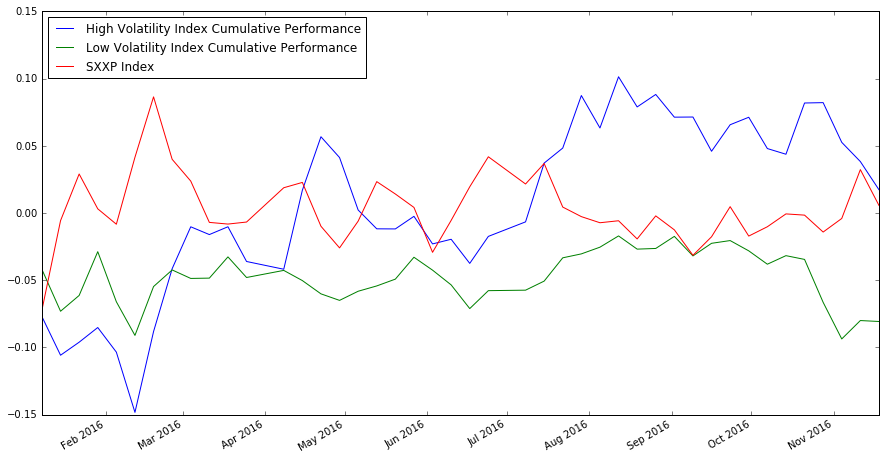

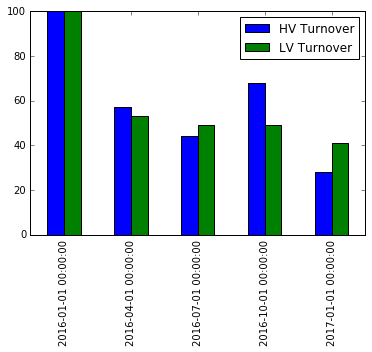

In [15]:
HV_Turnover=pd.DataFrame(pd.Series(Turnover_HV),columns=['HV Turnover'])
LV_Turnover=pd.DataFrame(pd.Series(Turnover_LV),columns=['LV Turnover'])

SXXP=(((1+SXXP_returns).cumprod())-1)

Y=pd.concat([(((1+High_vol_total_perf).cumprod())-1),(((1+Low_vol_total_perf).cumprod())-1),SXXP],axis=1,join="inner")[::-1]
Y.plot(figsize=(15,8));
Z=pd.concat([HV_Turnover,LV_Turnover],axis=1)
Z.plot(kind='bar')